# Plant Seedlings Classification

https://www.kaggle.com/c/plant-seedlings-classification/data

Determine the species of a seedling from an image

## 1. Load Data

In [1]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
data_dir = pathlib.Path('/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/plant-seedlings-classification')
image_count = len(list(data_dir.glob('train/*/*.png')))

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_dir = '/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/plant-seedlings-classification/train'
classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet']

train_data_gen = image_generator.flow_from_directory(directory=train_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = classes,
                                                     subset="training")

valid_data_gen = image_generator.flow_from_directory(directory=train_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = classes,
                                                     subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


## 2. Create Model

### 2.1 Basic Convolutional Neural Net

In [17]:
model_v1 = keras.Sequential()
model_v1.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_v1.add(keras.layers.Flatten())
model_v1.add(keras.layers.Dense(64, activation='relu'))
model_v1.add(keras.layers.Dense(12, activation='softmax'))
model_v1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

### 2.2 Resnet with pretrained weights on ImageNet

In [5]:
base_model_resnet = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                                               include_top=False,
                                               weights='imagenet')

In [10]:
base_model_resnet.trainable = True

for layer in base_model_resnet.layers[:150]:
  layer.trainable = False

len(base_model_resnet.layers)

# base_model_resnet.summary()

175

In [11]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
classification_layer = keras.layers.Dense(12, activation='softmax', kernel_regularizer= keras.regularizers.l2(0.001))
dropout_layer = keras.layers.Dropout(0.5)

In [12]:
model_v2 = tf.keras.Sequential([
  base_model_resnet,
  global_average_layer,
  dropout_layer,
  classification_layer
])

In [13]:
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                24588     
Total params: 23,612,300
Trainable params: 23,559,180
Non-trainable params: 53,120
_________________________________________________________________


## 3. Train Model

### 3.1 Training with Basic Convolutional Neural Net
Not enough flexibility in the model. Training loss decreases while Validation loss stays constant.

In [18]:
model_v1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model_v1_history = model_v1.fit(train_data_gen, epochs=10, steps_per_epoch=None, validation_data=valid_data_gen)

Train for 119 steps, validate for 30 steps
Epoch 1/10
119/119 [==============================] - 59s 499ms/step - loss: 2.3846 - accuracy: 0.1962 - val_loss: 1.9261 - val_accuracy: 0.3537
Epoch 2/10
119/119 [==============================] - 57s 478ms/step - loss: 1.4978 - accuracy: 0.4801 - val_loss: 1.3678 - val_accuracy: 0.5195
Epoch 3/10
119/119 [==============================] - 58s 488ms/step - loss: 1.1077 - accuracy: 0.6235 - val_loss: 1.0814 - val_accuracy: 0.6241
Epoch 4/10
119/119 [==============================] - 58s 485ms/step - loss: 0.9255 - accuracy: 0.6884 - val_loss: 0.9848 - val_accuracy: 0.6758
Epoch 5/10
119/119 [==============================] - 57s 476ms/step - loss: 0.7631 - accuracy: 0.7476 - val_loss: 1.0419 - val_accuracy: 0.6631
Epoch 6/10
119/119 [==============================] - 57s 477ms/step - loss: 0.6480 - accuracy: 0.7704 - val_loss: 0.9938 - val_accuracy: 0.6853
Epoch 7/10
119/119 [==============================] - 57s 479ms/step - loss: 0.5117 - a

### 3.2 Training with ResNet50

Is not feasible to use RestNet50 based on the lack of data. The model greatly overfit.

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [15]:
model_v2.compile(optimizer=get_optimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_v2_history = model_v2.fit(train_data_gen, epochs=10, steps_per_epoch=None, validation_data=valid_data_gen)

## 4. Evaluate on Test Data

### 4.1 Predicting with Basic Convolutional Neural Net

Received score of 0.70654 on Kaggle competition data.

In [21]:
test_dir = '/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/plant-seedlings-classification/'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_directory(directory=test_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = ['test'])

Found 794 images belonging to 1 classes.


In [22]:
pred = model_v1.predict(
    test_data_gen, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False,
)

In [23]:
y = np.argmax(pred, axis=1)

In [24]:
predicted_classes = [classes[i] for i in y]
files = [path[5:] for path in test_data_gen.filenames]

In [25]:
subm = np.stack([files,predicted_classes], axis=1)
np.savetxt('submission.csv', subm, fmt='%s,%s', header='file,species', comments='')

## 5. Analysis

### 5.1 Analysis of Basic Convolutional Neural Net

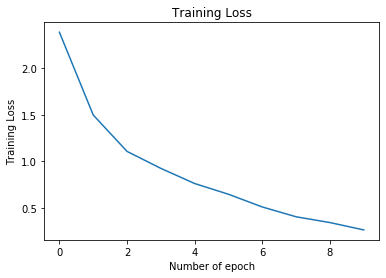

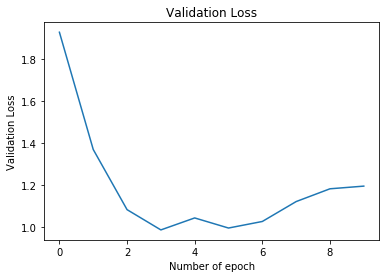

In [26]:
epochs = range(0, len(model_v1_history.history['loss']))
training_loss = model_v1_history.history['loss']
validation_loss = model_v1_history.history['val_loss']

# training loss 
plt.plot(epochs, training_loss)
plt.xlabel("Number of epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss")
plt.show()

# validation loss
plt.plot(epochs , validation_loss)
plt.xlabel("Number of epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss")
plt.show()